In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
import keras_nlp

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy
warnings.simplefilter(action='ignore')

In [4]:
# Load the MovieLens 100K dataset
# Assuming the file is 'u.data' in the same directory
# Columns: user_id, movie_id, rating, timestamp
data = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
data['rating'] = data['rating'] - 2
data = data[data['rating'] > 0]

# Step 0: only select top 50 movies
valid_movies = np.array(data['movie_id'].value_counts().index[:50])
data = data[data['movie_id'].isin(valid_movies)]

# Step 1: Remove users s.t. count >= 2 * unique timestamp
temp = data.groupby('user_id')['timestamp'].agg(['count', 'nunique']).reset_index()
valid_users = temp[temp['count']/temp['nunique'] < 2]['user_id']
data = data[data['user_id'].isin(valid_users)]

# Step 2: Remove users with only 1 rating
temp = data['user_id'].value_counts() 
one_rating = np.array(temp[temp == 1].index)
data = data[~data['user_id'].isin(one_rating)]

# Step 3: Deduplicate and recode
data = data.groupby(['user_id', 'timestamp'], group_keys=False).apply(lambda group: group.sample(n=1, random_state=42))
data = data.sort_values(['user_id', 'timestamp']).reset_index(drop = True)
data['movie_id'] = pd.factorize(data['movie_id'])[0] + 1

num_users = data['user_id'].nunique()
num_movies = data['movie_id'].nunique()
num_ratings = len(data)

sparsity = 1 - (num_ratings / (num_users * num_movies))

print(f"Filtered Dataset: {num_users} users, {num_movies} movies")
print(f"Sparsity: {sparsity:.2%}")

Filtered Dataset: 893 users, 50 movies
Sparsity: 72.08%


ACTUAL: (30, 2), (29, 3), (31, 1), (23, 2), (0, 0), (0, 0)

Suppose we want to predict the rating of movie 31 (MASK TOKEN = 4 since rating is either 1, 2, or 3)

INPUT: (30, 2), (29, 3), (31, 4), (23, 2), (0, 0), (0, 0)

1. Embed movie and rating
2. Concatenate embedding
3. Add pos. emb.
4. Apply self-attention and take the representation corresponding to movie 31.
5. Apply a dense layer with exp. activation to predict the rating

In [5]:
np.random.seed(42)

all_users = data['user_id'].unique()
shuffled_indices = np.random.permutation(len(all_users))

midpoint = 3 * len(all_users) // 4
indices_1 = shuffled_indices[:midpoint]
indices_2 = shuffled_indices[midpoint:]

train_users = shuffled_indices[indices_1]
test_users = shuffled_indices[indices_2]

In [6]:
data_train = data[data['user_id'].isin(train_users)].reset_index(drop = True)
data_test = data[data['user_id'].isin(test_users)].reset_index(drop = True)

In [7]:
data[data['user_id'] == 2]

,user_id,movie_id,rating,timestamp
29,2,30,2,888549960
30,2,29,1,888549961
31,2,31,1,888550252
32,2,23,2,888550774
33,2,4,2,888550871
34,2,32,3,888550939
35,2,33,2,888551062
36,2,34,2,888551552
37,2,35,2,888552017
38,2,36,3,888552084


In [8]:
def preprocess_data(df):
    
    movie = []  ## (30, 29, 31, 23, 0, 0)
    rating = [] ## (2, 3, 4, 2, 0, 0)
    length = [] ## 4
    pred_idx = [] ## 2
    target = [] ## 1
    
    unique_user_ids = df['user_id'].unique()
    mask_rating_token = df['rating'].max() + 1
    
    for user_id in unique_user_ids:

        temp = df[df['user_id'] == user_id]
        movie_list, rating_list = list(temp['movie_id']), list(temp['rating'])
        target += rating_list
        
        for idx in range(temp.shape[0]):
            movie.append(movie_list)
            rating.append(rating_list[:idx] + [mask_rating_token] + rating_list[(idx+1):])
            length.append(temp.shape[0])
            pred_idx.append(idx)
            
    return movie, rating, length, pred_idx, target

In [9]:
movie_train, rating_train, length_train, pred_idx_train, target_train \
    = preprocess_data(data_train)

movie_test, rating_test, length_test, pred_idx_test, target_test \
    = preprocess_data(data_test)

In [10]:
movie_train, movie_val, rating_train, rating_val, \
length_train, length_val, pred_idx_train, pred_idx_val, \
target_train, target_val = train_test_split(
    movie_train, rating_train, length_train, pred_idx_train, target_train, 
    test_size=0.25, random_state=42
)

In [11]:
max_ctx = max(length_train + length_test + length_val)

In [12]:
movie_train = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_train]

movie_val = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_val]

movie_test = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_test]

rating_train = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_train]

rating_val = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_val]

rating_test = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_test]

In [13]:
movie_train_data = np.array(movie_train)  # Context movies
rating_train_data = np.array(rating_train)  # Context ratings
length_train_data = np.array(length_train)  # Length of the context
pred_idx_train_data = np.array(pred_idx_train)   # Index of masked token
target_train_data = np.array(target_train)  # Target rating

movie_val_data = np.array(movie_val)  # Context movies
rating_val_data = np.array(rating_val)  # Context ratings
length_val_data = np.array(length_val)  # Length of the context
pred_idx_val_data = np.array(pred_idx_val)   # Index of masked token
target_val_data = np.array(target_val)  # Target rating

movie_test_data = np.array(movie_test)  # Context movies
rating_test_data = np.array(rating_test)  # Context ratings
length_test_data = np.array(length_test)  # Length of the context
pred_idx_test_data = np.array(pred_idx_test)   # Index of masked token
target_test_data = np.array(target_test)  # Target rating

In [14]:
embedding_size = 32
movie_input_dim = data['movie_id'].nunique() + 1
rating_input_dim = data['rating'].nunique() + 2

movie_input = layers.Input(shape=(max_ctx,), dtype=tf.int32, name="movie_input")  
rating_input = layers.Input(shape=(max_ctx,), dtype=tf.float32, name="rating_input")  

movie_embedding = layers.Embedding(input_dim=movie_input_dim, output_dim=embedding_size)(movie_input)
rating_embedding = layers.Embedding(input_dim=rating_input_dim, output_dim=embedding_size)(rating_input)
combined_embedding = layers.Concatenate()([movie_embedding, rating_embedding])

position_embedding = keras_nlp.layers.PositionEmbedding(sequence_length=max_ctx)(combined_embedding)
final_embedding = combined_embedding + position_embedding

length_input = layers.Input(shape=(1,), dtype=tf.int32, name="length_input")

class DynamicMaskLayer(layers.Layer):
    def call(self, inputs):
        seq_len = tf.shape(inputs[0])[1]  
        lengths = tf.cast(inputs[1], dtype=tf.int32)  
        seq_range = tf.range(seq_len, dtype=tf.int32)
        seq_range_expanded = tf.expand_dims(seq_range, axis=0)
        mask = tf.cast(seq_range_expanded < lengths, dtype=tf.float32) 
        return mask[:, tf.newaxis, tf.newaxis, :]

attention_mask = DynamicMaskLayer()([final_embedding, length_input])

attention_layer_1 = MultiHeadAttention(num_heads=2, key_dim=16, name="multi_head_attention_1")
attn_output_1 = attention_layer_1(
    query=final_embedding,
    value=final_embedding,
    key=final_embedding,
    attention_mask=attention_mask
)

attn_output_1 = final_embedding + attn_output_1

attention_layer_2 = MultiHeadAttention(num_heads=2, key_dim=16, name="multi_head_attention_2")
attn_output_2 = attention_layer_2(
    query=attn_output_1,
    value=attn_output_1,
    key=attn_output_1,
    attention_mask=attention_mask
)

context_embedding = attn_output_1 + attn_output_2

pred_idx_input = layers.Input(shape=(1,), dtype=tf.int32, name="pred_idx_input")

class GatherLayer(layers.Layer):
    def call(self, inputs):
        context_embedding, pred_idx_input = inputs
        return tf.gather(context_embedding, indices=tf.squeeze(pred_idx_input, axis=-1), batch_dims=1)

extracted_embeddings = GatherLayer()([context_embedding, pred_idx_input])

hidden_layer = layers.Dense(32, activation='relu')(extracted_embeddings)
output_layer_exp = layers.Dense(1, activation='exponential')(hidden_layer)

model = Model(inputs=[movie_input, rating_input, length_input, pred_idx_input], 
              outputs=output_layer_exp)

#### score follows a Poisson distribution with mean 1 + exp(.)

def poisson_log_likelihood(y_true, y_pred):
    epsilon = 1e-8
    return tf.reduce_mean(1 + y_pred - y_true * tf.math.log(1 + y_pred))

model.compile(optimizer=Adam(learning_rate = 1e-4), loss=poisson_log_likelihood)

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=10,  
    restore_best_weights=True 
)

# Fit the model with validation data and early stopping
history = model.fit(
    [movie_train_data, rating_train_data, length_train_data, pred_idx_train_data], 
    target_train_data,        
    validation_data=([movie_val_data, rating_val_data, length_val_data, pred_idx_val_data], target_val_data),  
    epochs=1000,                 
    batch_size=256,            
    callbacks=[early_stopping] 
)

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.5351 - val_loss: 0.5310
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5291 - val_loss: 0.5297
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5253 - val_loss: 0.5284
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5377 - val_loss: 0.5268
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5193 - val_loss: 0.5246
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5170 - val_loss: 0.5218
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5129 - val_loss: 0.5193
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5130 - val_loss: 0.5178
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5251 - val_loss: 0.5171
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5230 - val_loss: 0.5165
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.5149 - val_loss: 0.5161
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie_input         │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_input        │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 44, 32)    │      1,632 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 44, 32)    │        160 │ rating_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 44, 64)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 44, 64)    │      2,816 │ concatenate[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 44, 64)    │          0 │ concatenate[0][0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ length_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_mask_layer  │ (None, 1, 1, 44)  │          0 │ add[0][0],        │
│ (DynamicMaskLayer)  │                   │            │ length_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 44, 64)    │      8,352 │ dynamic_mask_lay… │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 44, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 44, 64)    │      8,352 │ dynamic_mask_lay… │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0],      │
│                     │                   │            │ add_1[0][0],      │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 44, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_idx_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gather_layer        │ (None, 64)        │          0 │ add_2[0][0],      │
│ (GatherLayer)       │                   │            │ pred_idx_input[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 70,277 (274.52 KB)

 Trainable params: 23,425 (91.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,852 (183.02 KB)

In [16]:
test_loss = model.evaluate([movie_test_data, rating_test_data, length_test_data, pred_idx_test_data], target_test_data)
print(f"Test Loss: {test_loss}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4642
Test Loss: 0.49417635798454285


In [17]:
pred_test_ratings = model.predict([movie_test_data, rating_test_data, length_test_data, pred_idx_test_data]).flatten()

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


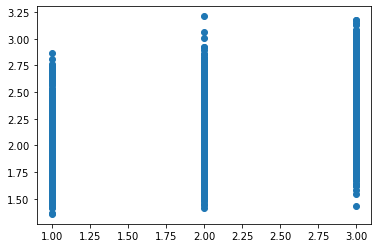

In [18]:
plt.scatter(target_test_data, pred_test_ratings + 1);

In [19]:
(pred_test_ratings + 1)[target_test_data == 1].mean(), \
    (pred_test_ratings + 1)[target_test_data == 2].mean(), \
        (pred_test_ratings + 1)[target_test_data == 3].mean()

(1.944201, 2.0777252, 2.3128188)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie_input         │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_input        │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 44, 32)    │      1,632 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 44, 32)    │        160 │ rating_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 44, 64)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 44, 64)    │      2,816 │ concatenate[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 44, 64)    │          0 │ concatenate[0][0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ length_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dynamic_mask_layer  │ (None, 1, 1, 44)  │          0 │ add[0][0],        │
│ (DynamicMaskLayer)  │                   │            │ length_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 44, 64)    │      8,352 │ dynamic_mask_lay… │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 44, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 44, 64)    │      8,352 │ dynamic_mask_lay… │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0],      │
│                     │                   │            │ add_1[0][0],      │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 44, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_idx_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gather_layer        │ (None, 64)        │          0 │ add_2[0][0],      │
│ (GatherLayer)       │                   │            │ pred_idx_input[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 70,277 (274.52 KB)

 Trainable params: 23,425 (91.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,852 (183.02 KB)